# To make a wedge

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Make a wavelet, or import one from SciPy

In [2]:
import numpy as np
from scipy.signal import ricker
import matplotlib.pyplot as plt

We also need to make a physical earth model with three rock layers. In this example, let's make up an acoustic impedance earth model, and to keep it simple, let's define the earth model with two-way travel time along the earth axis.

In [3]:
n_samples, n_traces = [600,500]

rock_grid = np.zeros((n_samples, n_traces))

def make_wedge(n_sampless, n_traces, layer_1_thickness, start_wedge, end_wedge):
    
    for j in np.arange(n_traces): 
    
        for i in np.arange(n_samples):      
            if i <= layer_1_thickness:      
                rock_grid[i][j] = 1    
            
            if i > layer_1_thickness:         
                rock_grid[i][j] = 3    
                
                if j >= start_wedge and i - layer_1_thickness < j-start_wedge: 
                    rock_grid[i][j] = 2
                    
                    if j >= end_wedge and i > layer_1_thickness+(end_wedge-start_wedge):
                        rock_grid[i][j] = 3
    return rock_grid

We can plot the layers that we have just created
Note these are just indicies 1, 2, and 3

In [4]:
layer_1_thickness = 180
start_wedge = 25 # trace location where wedge starts 
end_wedge = 150 # trace location where wedge ends 
rock_grid = make_wedge(n_samples, n_traces, layer_1_thickness, start_wedge, end_wedge)

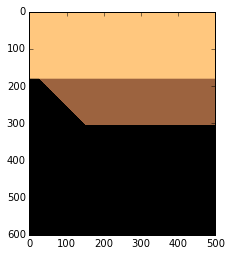

In [6]:
plt.imshow(rock_grid, cmap = 'copper_r')
plt.show()

Now we can give each layer in the wedge model some properties, in SI units:

In [7]:
vp = np.array([3300.,3200.,3300.]) # P-wave velocity of each layer (SI units)
rho = np.array([2600.,2550.,2650.]) # bulk densities of each layer (SI units)
AI = vp * rho
AI = AI / 10e6 # Re-scale so we don't have to write out huge numbers (optional)
print AI

[ 0.858   0.816   0.8745]


We can now use the acoustic impedance values and assign them accordingly to every sample in the rocks.

In [8]:
model = np.copy(rock_grid)
model[rock_grid == 1] = AI[0]
model[rock_grid == 2] = AI[1]
model[rock_grid == 3] = AI[2]

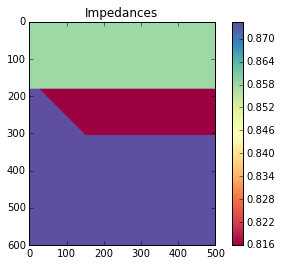

In [9]:
plt.imshow(model, cmap='Spectral')
plt.colorbar()
plt.title('Impedances')
plt.show()

Now we compute reflection coeffcients,

In [10]:
upper = model[:-1][:]
lower = model[1:][:]
rc = (lower - upper) / (lower + upper)
maxrc = np.amax(abs(rc)) #find maximum reflection coefficient for scaling plots

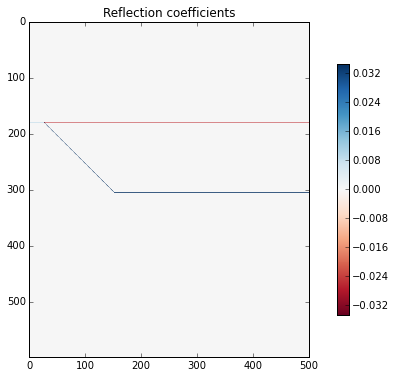

In [11]:
plt.figure(figsize=(10, 6))
plt.imshow(rc, cmap='RdBu', vmax=maxrc, vmin=-maxrc)
plt.colorbar(shrink=0.75)
plt.title('Reflection coefficients')
plt.show()

Now we make a wavelet and interact it with the model using NumPy's <code>convolve</code> function

In [12]:
def make_synth(f):
    nt=512
    synth = np.zeros((n_samples+nt-2, n_traces))
    wavelet = ricker(nt, 1e3/(4.*f))
    wavelet = wavelet / max(wavelet)   #normalize the wavelet
    for i in range(n_traces):
        synth[:,i] = np.convolve(rc[:,i], wavelet)
    synth = synth[ceil(len(wavelet))/2:-ceil(len(wavelet))/2, :]
    return synth

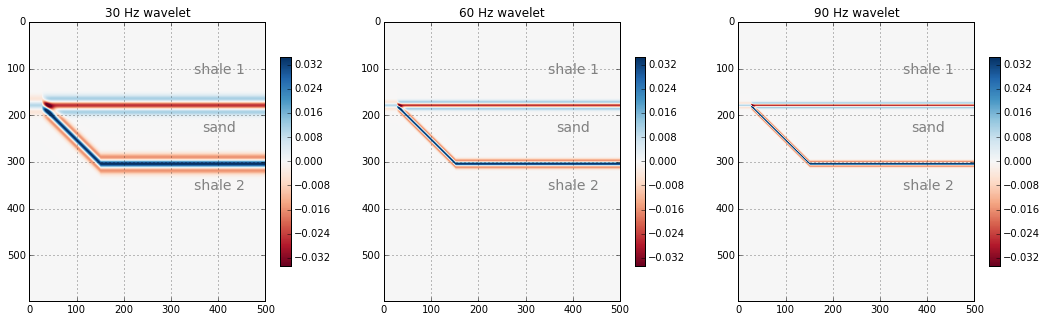

In [25]:
frequencies = np.array([30,60,90])
rock_names = ['shale 1','sand','shale 2' ]

plt.figure(figsize = (18,5))
slices = [];
for i in np.arange(len(frequencies)):
    this_plot = make_synth(frequencies[i])
    plt.subplot(1, len(frequencies), i+1)
    plt.imshow(this_plot, cmap='RdBu', vmax=maxrc, vmin=-maxrc, aspect=1)
    plt.title( '%d Hz wavelet' % frequencies[i] )
    plt.grid()
    plt.axis('tight')
    plt.colorbar(shrink=0.75)
    slices.append(this_plot)
    
    
    # Add some labels
    for i, names in enumerate(rock_names):
        plt.text(400, 100+((end_wedge-start_wedge)*i+1), names,
                 fontsize = 14, color='gray',
                 horizontalalignment='center',
                 verticalalignment='center')

model_x, model_y = this_plot.shape[0],this_plot.shape[1]

In [14]:
model_x, model_y
frequencies = np.array([5,10,15])
RGB_array= np.zeros((model_x,model_y,3))
cbands = ['Reds_r', 'Greens_r', 'Blues_r']
rock_names = ['shale 1','sand','shale 2' ]

for item, band in enumerate(cbands):
    this_plot = make_synth(frequencies[item])
    RGB_array[:,:,i]=this_plot

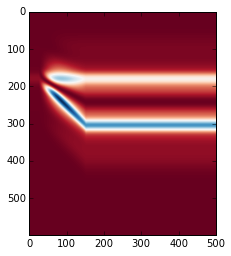

1.0

In [27]:
RGB_array= np.zeros((model_x,model_y,3))
Raw_array= np.zeros((model_x,model_y,3))

fff = [5,8,12]
#raw1 = (make_synth(5))
#raw2 = (make_synth(8))
#raw3 = (make_synth(12))

for i in range(3):
    Raw_array[:,:,i] = make_synth(fff[i])

rms1 = (make_synth(5)**2)
rms2 = (make_synth(8)**2)
rms3 = (make_synth(12)**2)

RGB_array[:,:,0]= rms1/np.amax(rms1)
RGB_array[:,:,1]= rms2/np.amax(rms2)
RGB_array[:,:,2]= rms3/np.amax(rms3)

plt.imshow( sum(RGB_array, axis=-1),cmap='RdBu', aspect=1)
plt.show()

RGB_array.ptp()

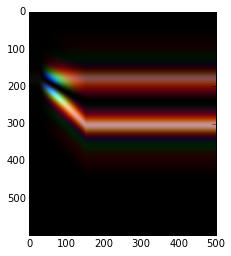

In [29]:
import scipy
scipy.misc.imsave( 'scipy_rgb_array.png', RGB_array*255.0)
plt.imshow( RGB_array)